In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [44]:
def analyser_polluant_complet(nom_polluant: str, dossier_base: str = "data"):
    def to_6h_slot(dt): return dt.floor('6H')

    chemin = os.path.join(dossier_base, nom_polluant)
    fichiers_csv = sorted([f for f in os.listdir(chemin) if f.endswith(".csv")])

    df_list = []
    for fichier in fichiers_csv:
        df = pd.read_csv(os.path.join(chemin, fichier))
        df["année"] = fichier[:4]
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_all["time"] = pd.to_datetime(df_all["time"])
    colonnes_stations = df_all.columns.difference(["time", "année"])
    df_all[f"{nom_polluant}_moyenne"] = df_all[colonnes_stations].mean(axis=1)

    # --- 1. ÉVOLUTION GLOBALE ---
    df_filtered = df_all[df_all["time"] >= "2024-01-01"]
    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered["time"], df_filtered[f"{nom_polluant}_moyenne"], label=f"{nom_polluant} moyenne (toutes stations)", color="teal")
    plt.axhline(50, color='red', linestyle='--', label='Seuil OMS journalier')  # ajustable
    plt.title(f"Évolution moyenne horaire des {nom_polluant} – depuis janvier 2024")
    plt.xlabel("Date")
    plt.ylabel(f"{nom_polluant} (µg/m³)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2. MOYENNES PAR PÉRIODE POLITIQUE ---
    date0 = df_all["time"].min()
    date1 = pd.Timestamp("2024-10-01")
    date2 = pd.Timestamp("2025-03-01")
    date3 = df_all["time"].max()
    m1 = df_all.loc[df_all["time"] < date1, f"{nom_polluant}_moyenne"].mean()
    m2 = df_all.loc[(df_all["time"] >= date1) & (df_all["time"] < date2), f"{nom_polluant}_moyenne"].mean()
    m3 = df_all.loc[df_all["time"] >= date2, f"{nom_polluant}_moyenne"].mean()

    variation_1_2 = ((m2 - m1) / m1) * 100
    variation_2_3 = ((m3 - m2) / m2) * 100

    print(f"\n--- {nom_polluant} : Moyennes par période ---")
    print(f"Avant oct. 2024 : {m1:.2f} µg/m³")
    print(f"Oct. 2024 – mars 2025 : {m2:.2f} µg/m³ ({variation_1_2:+.1f} % vs période 1)")
    print(f"Après mars 2025 : {m3:.2f} µg/m³ ({variation_2_3:+.1f} % vs période 2)")

    plt.figure(figsize=(14, 6))
    plt.plot(df_all["time"], df_all[f"{nom_polluant}_moyenne"], label=f"{nom_polluant} moyenne horaire", color="gray", alpha=0.4)
    plt.plot([date0, date1], [m1]*2, color="blue", linestyle="--", label=f"Avant oct. 2024 ({m1:.1f} µg/m³)")
    plt.plot([date1, date2], [m2]*2, color="orange", linestyle="--", label=f"Oct. 24 - mars 25 ({m2:.1f} µg/m³)")
    plt.plot([date2, date3], [m3]*2, color="green", linestyle="--", label=f"Après mars 2025 ({m3:.1f} µg/m³)")
    plt.axvline(date1, color="black", linestyle=":", alpha=0.6)
    plt.axvline(date2, color="black", linestyle=":", alpha=0.6)
    plt.title(f"{nom_polluant} – Moyennes par période d'analyse")
    plt.xlabel("Date")
    plt.ylabel(f"{nom_polluant} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3. COMPARAISONS MENSUELLES : FÉVRIER & AVRIL ---
    for mois, nom_mois in [(2, "Février"), (4, "Avril")]:
        df_2024 = df_all[(df_all["time"].dt.month == mois) & (df_all["time"].dt.year == 2024)].copy()
        df_2025 = df_all[(df_all["time"].dt.month == mois) & (df_all["time"].dt.year == 2025)].copy()

        df_2024["slot_6h"] = df_2024["time"].apply(to_6h_slot)
        df_2025["slot_6h"] = df_2025["time"].apply(to_6h_slot)

        g_2024 = df_2024.groupby("slot_6h")[f"{nom_polluant}_moyenne"].mean().reset_index()
        g_2025 = df_2025.groupby("slot_6h")[f"{nom_polluant}_moyenne"].mean().reset_index()
        g_2024["relative_time"] = g_2024["slot_6h"].dt.strftime("%d-%Hh")
        g_2025["relative_time"] = g_2025["slot_6h"].dt.strftime("%d-%Hh")

        m_2024 = g_2024[f"{nom_polluant}_moyenne"].mean()
        m_2025 = g_2025[f"{nom_polluant}_moyenne"].mean()
        delta = ((m_2025 - m_2024) / m_2024) * 100

        leg_2024 = f"{nom_mois} 2024 ({m_2024:.1f} µg/m³)"
        leg_2025 = f"{nom_mois} 2025 ({m_2025:.1f} µg/m³, {delta:+.1f}%)"

        print(f"\n--- {nom_polluant} : Comparaison {nom_mois} ---")
        print(f"{nom_mois} 2024 : {m_2024:.2f} µg/m³")
        print(f"{nom_mois} 2025 : {m_2025:.2f} µg/m³")
        print(f"Différence : {m_2025 - m_2024:+.2f} µg/m³ ({delta:+.1f}%)")

        plt.figure(figsize=(14, 6))
        plt.plot(g_2024["relative_time"], g_2024[f"{nom_polluant}_moyenne"], label=leg_2024, color="blue")
        plt.plot(g_2025["relative_time"], g_2025[f"{nom_polluant}_moyenne"], label=leg_2025, color="red")
        plt.hlines(m_2024, xmin=0, xmax=len(g_2024)-1, colors="blue", linestyles="--", alpha=0.5)
        plt.hlines(m_2025, xmin=0, xmax=len(g_2025)-1, colors="red", linestyles="--", alpha=0.5)

        xticks = g_2024["relative_time"]
        xtick_labels = [t[:2] if i % 4 == 0 else "" for i, t in enumerate(xticks)]
        plt.xticks(ticks=range(len(xticks)), labels=xtick_labels, rotation=0)

        plt.title(f"{nom_polluant} – Comparaison {nom_mois} 2024 vs 2025 (par tranches de 6h)")
        plt.xlabel("Jour du mois")
        plt.ylabel(f"{nom_polluant} (µg/m³)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f"Analyse complète pour {nom_polluant} terminée."

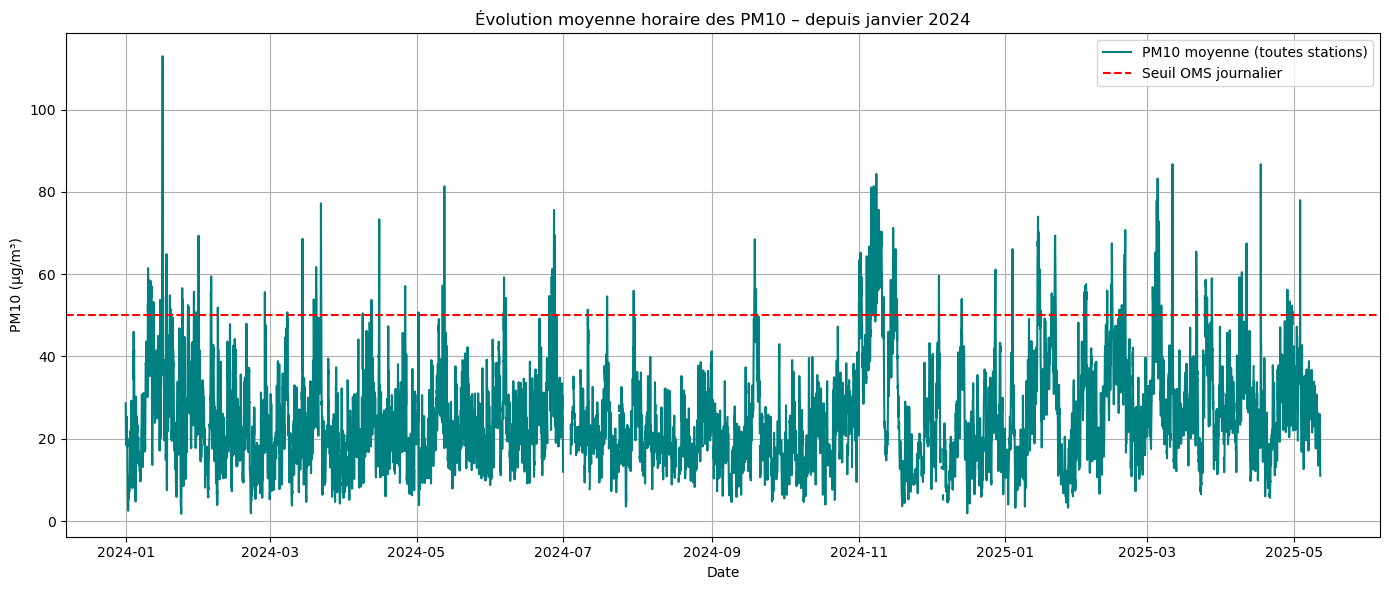


--- PM10 : Moyennes par période ---
Avant oct. 2024 : 22.81 µg/m³
Oct. 2024 – mars 2025 : 26.64 µg/m³ (+16.8 % vs période 1)
Après mars 2025 : 29.13 µg/m³ (+9.3 % vs période 2)


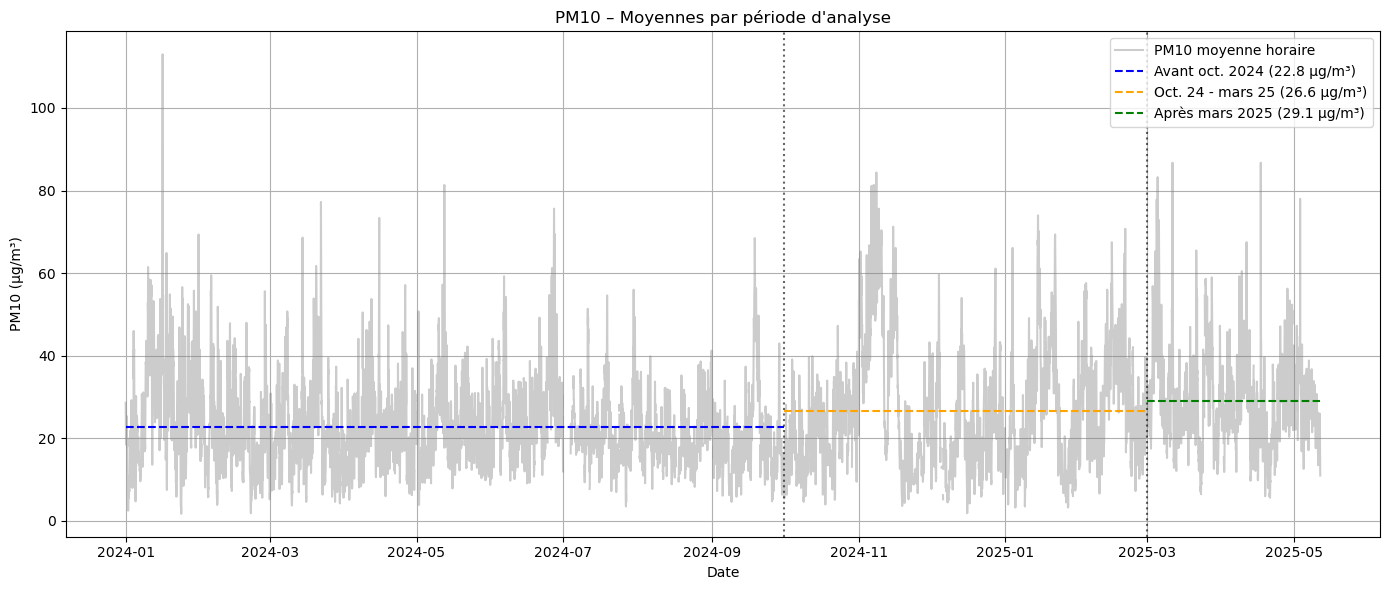

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- PM10 : Comparaison Février ---
Février 2024 : 21.37 µg/m³
Février 2025 : 31.12 µg/m³
Différence : +9.75 µg/m³ (+45.6%)


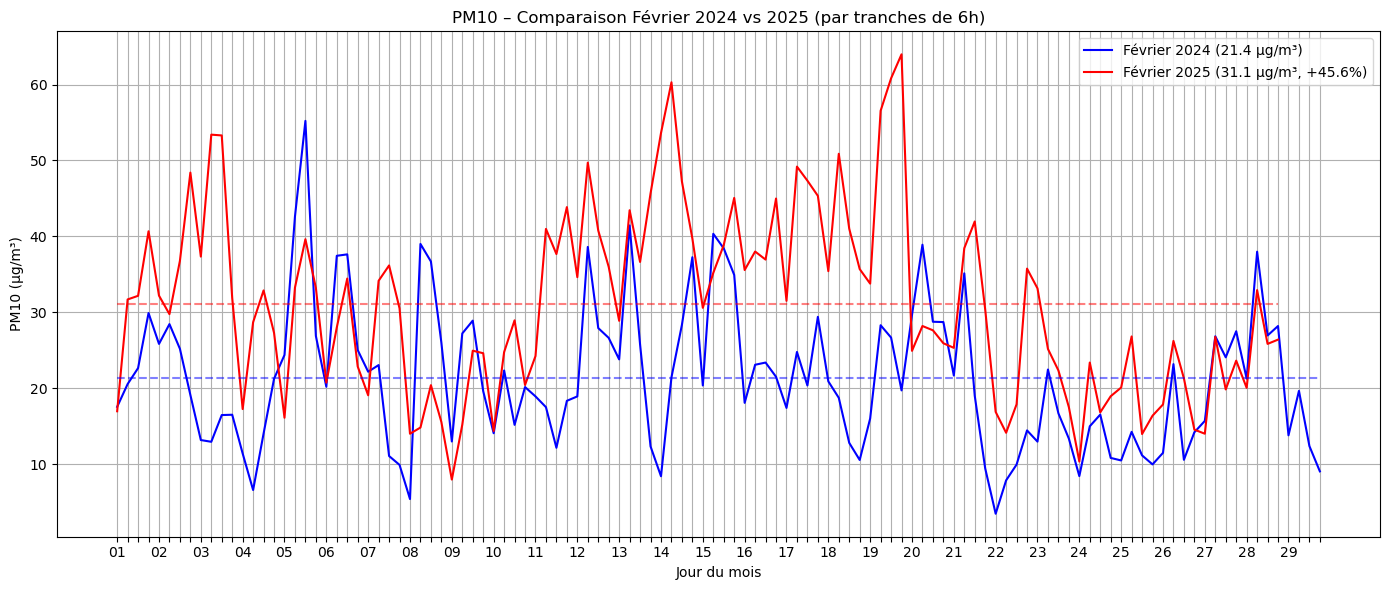

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- PM10 : Comparaison Avril ---
Avril 2024 : 21.98 µg/m³
Avril 2025 : 27.62 µg/m³
Différence : +5.64 µg/m³ (+25.7%)


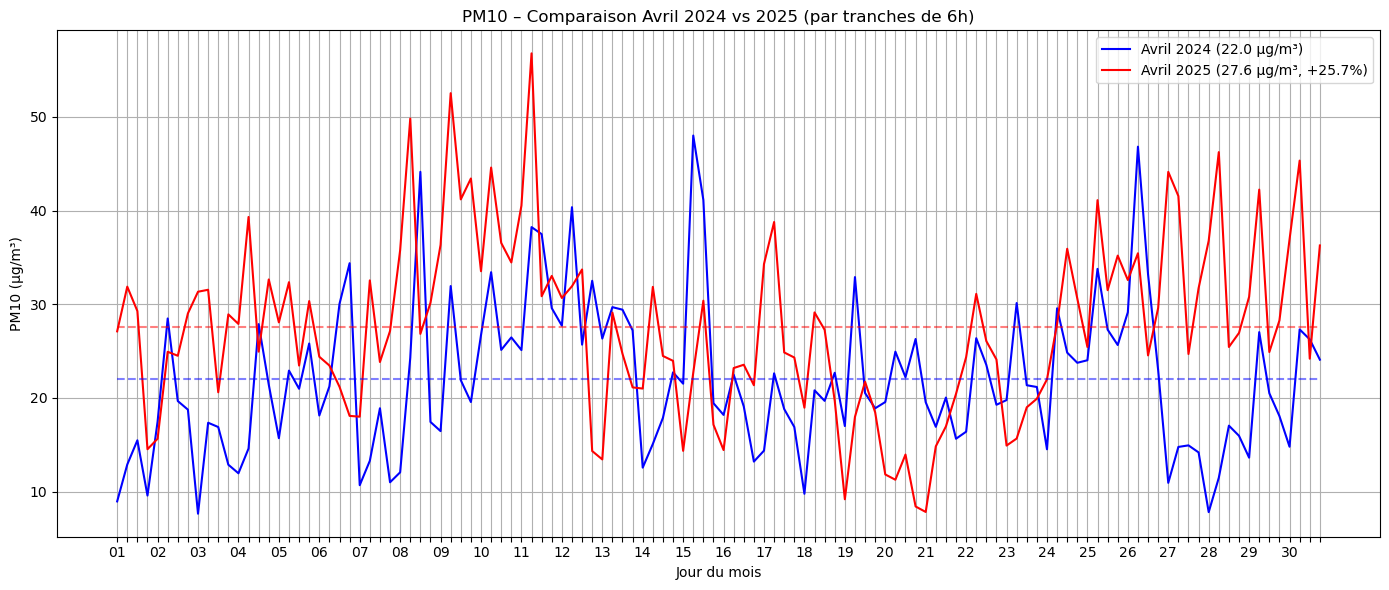

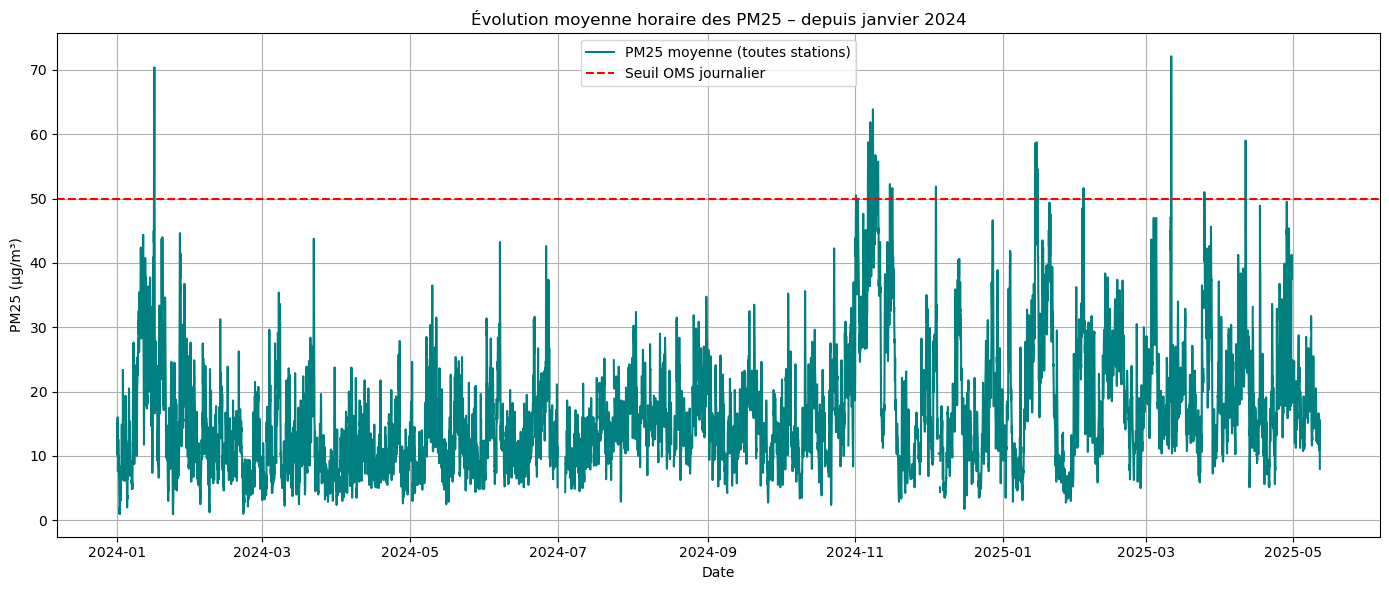


--- PM25 : Moyennes par période ---
Avant oct. 2024 : 13.56 µg/m³
Oct. 2024 – mars 2025 : 19.98 µg/m³ (+47.3 % vs période 1)
Après mars 2025 : 20.05 µg/m³ (+0.4 % vs période 2)


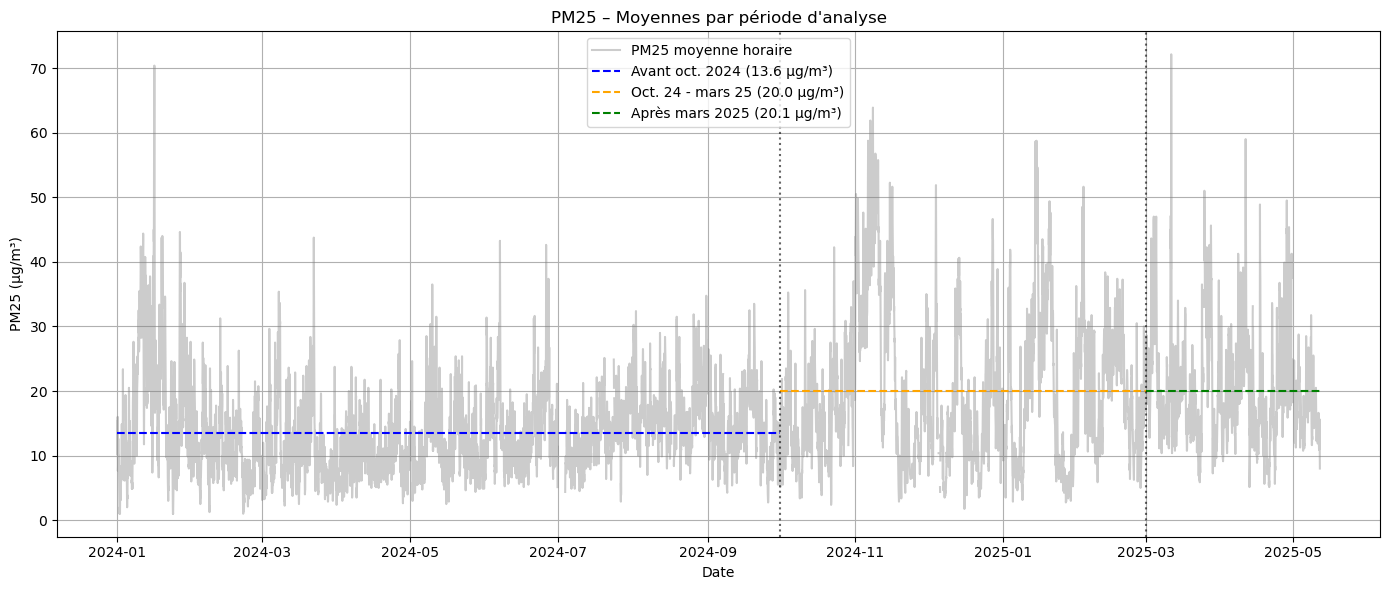

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- PM25 : Comparaison Février ---
Février 2024 : 10.81 µg/m³
Février 2025 : 21.12 µg/m³
Différence : +10.31 µg/m³ (+95.4%)


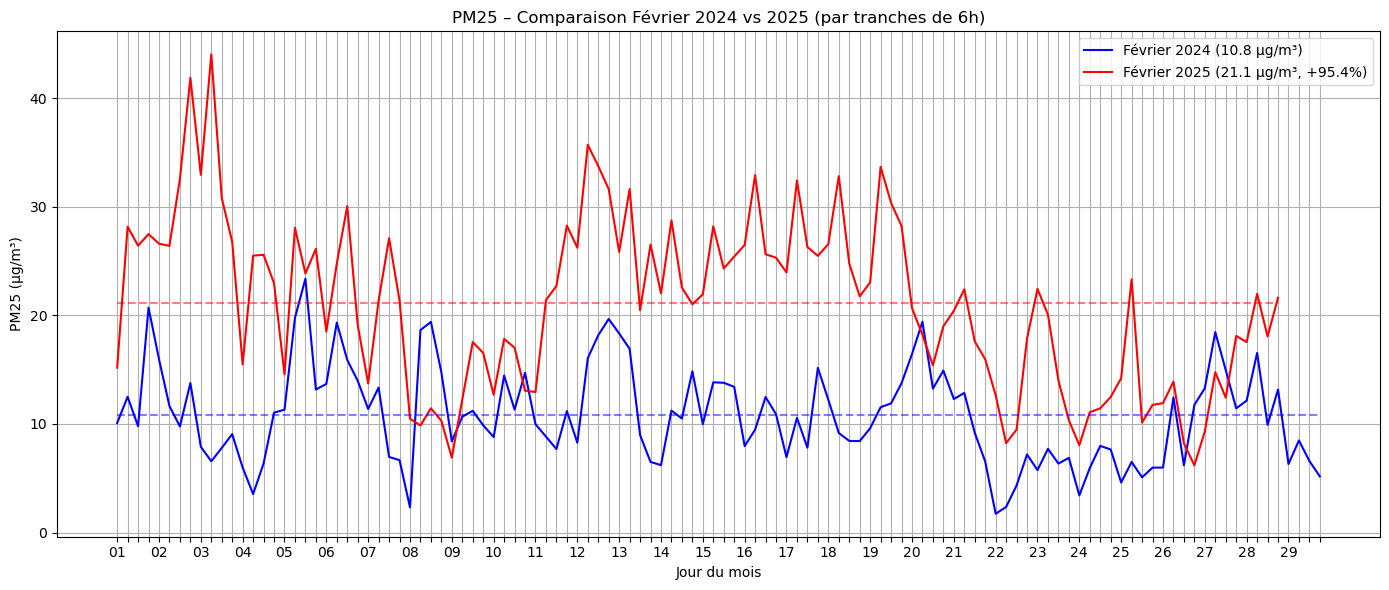

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- PM25 : Comparaison Avril ---
Avril 2024 : 9.92 µg/m³
Avril 2025 : 20.16 µg/m³
Différence : +10.24 µg/m³ (+103.2%)


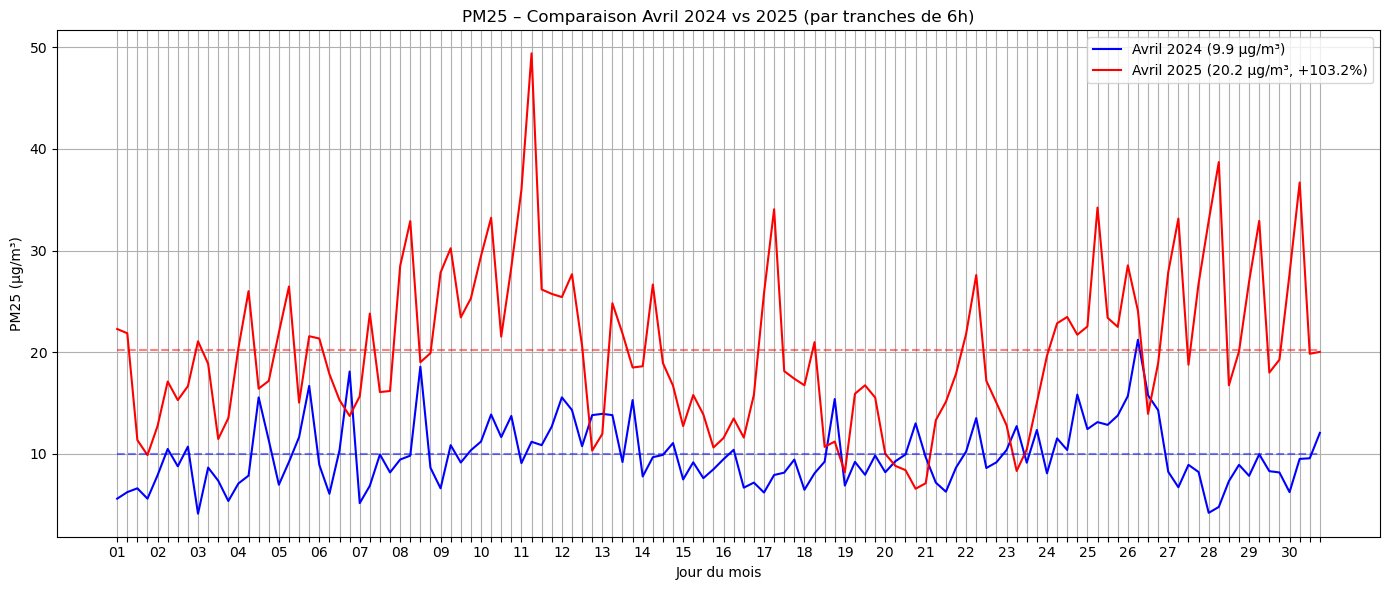

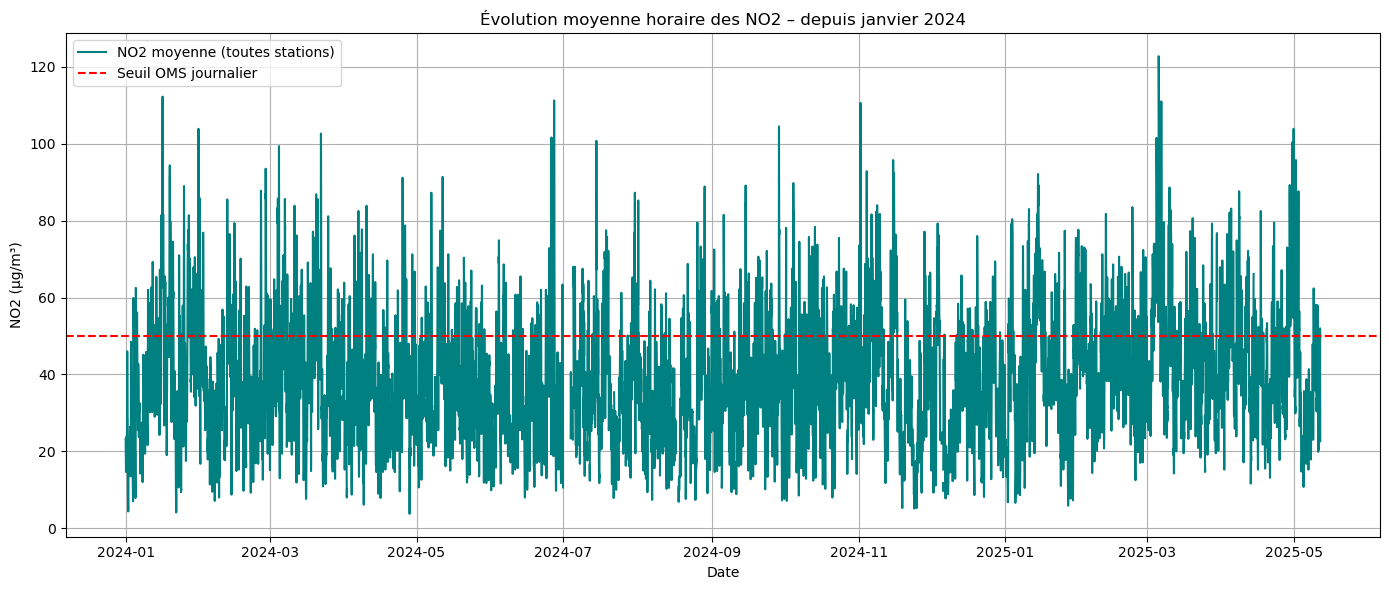


--- NO2 : Moyennes par période ---
Avant oct. 2024 : 36.93 µg/m³
Oct. 2024 – mars 2025 : 39.81 µg/m³ (+7.8 % vs période 1)
Après mars 2025 : 43.40 µg/m³ (+9.0 % vs période 2)


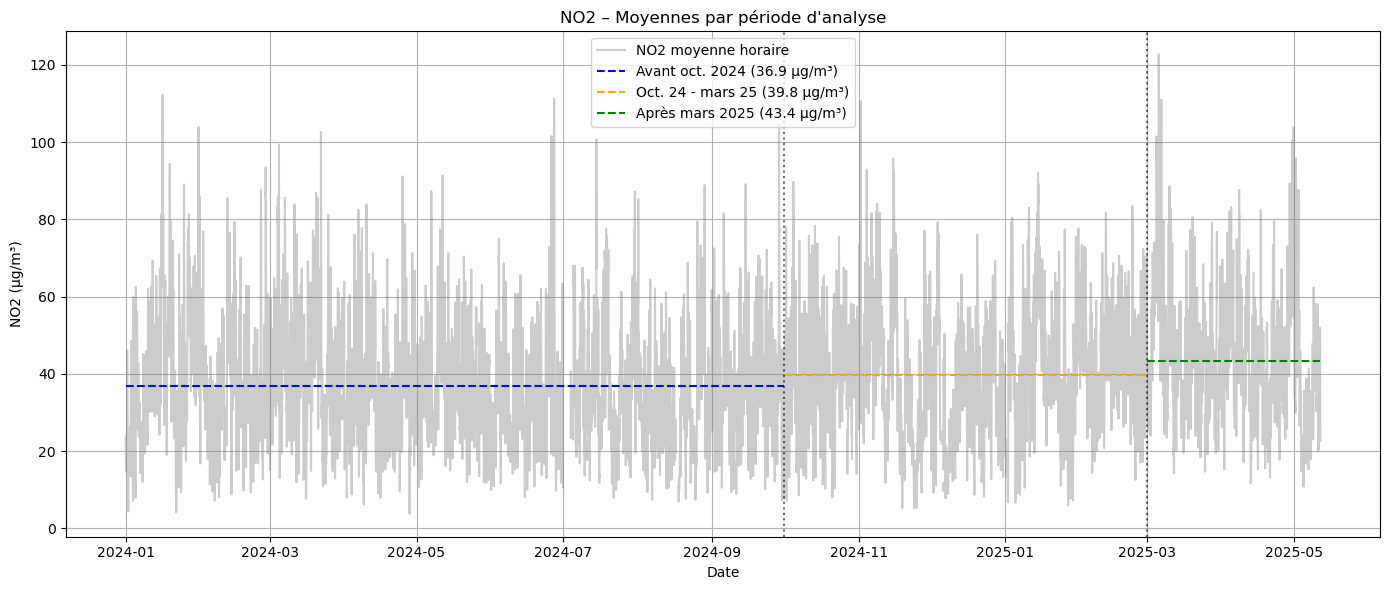

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- NO2 : Comparaison Février ---
Février 2024 : 36.00 µg/m³
Février 2025 : 44.05 µg/m³
Différence : +8.04 µg/m³ (+22.3%)


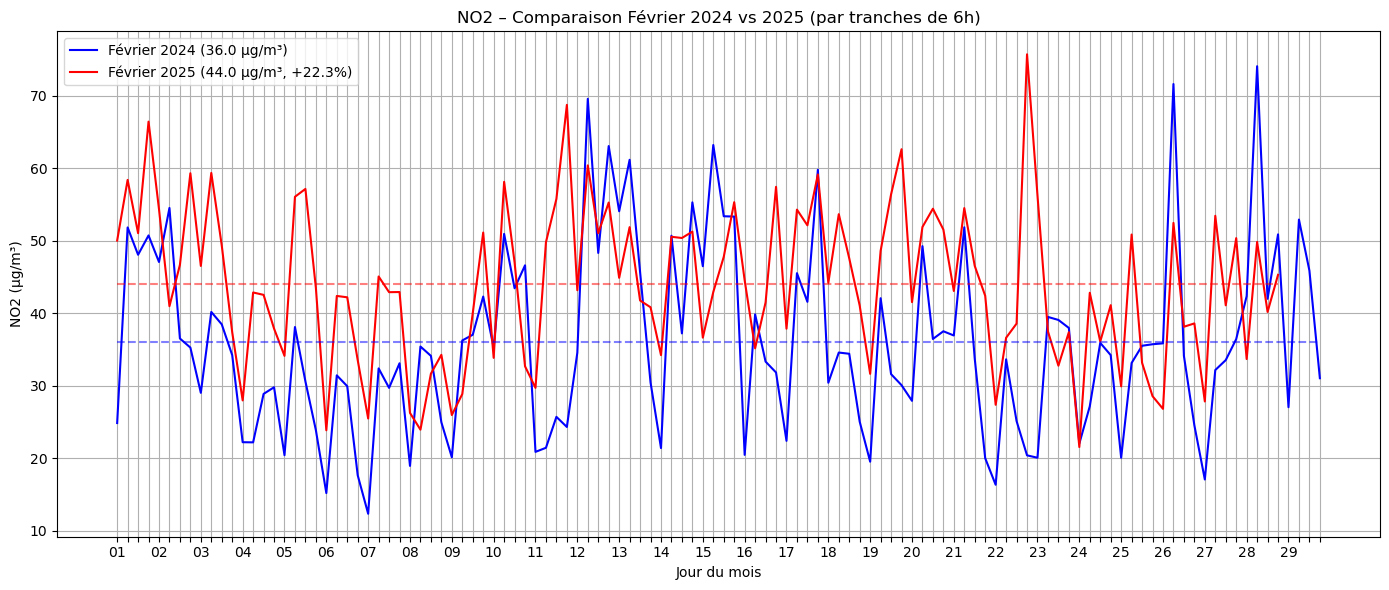

/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_36064/3397752939.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  def to_6h_slot(dt): return dt.floor('6H')



--- NO2 : Comparaison Avril ---
Avril 2024 : 35.13 µg/m³
Avril 2025 : 44.32 µg/m³
Différence : +9.19 µg/m³ (+26.2%)


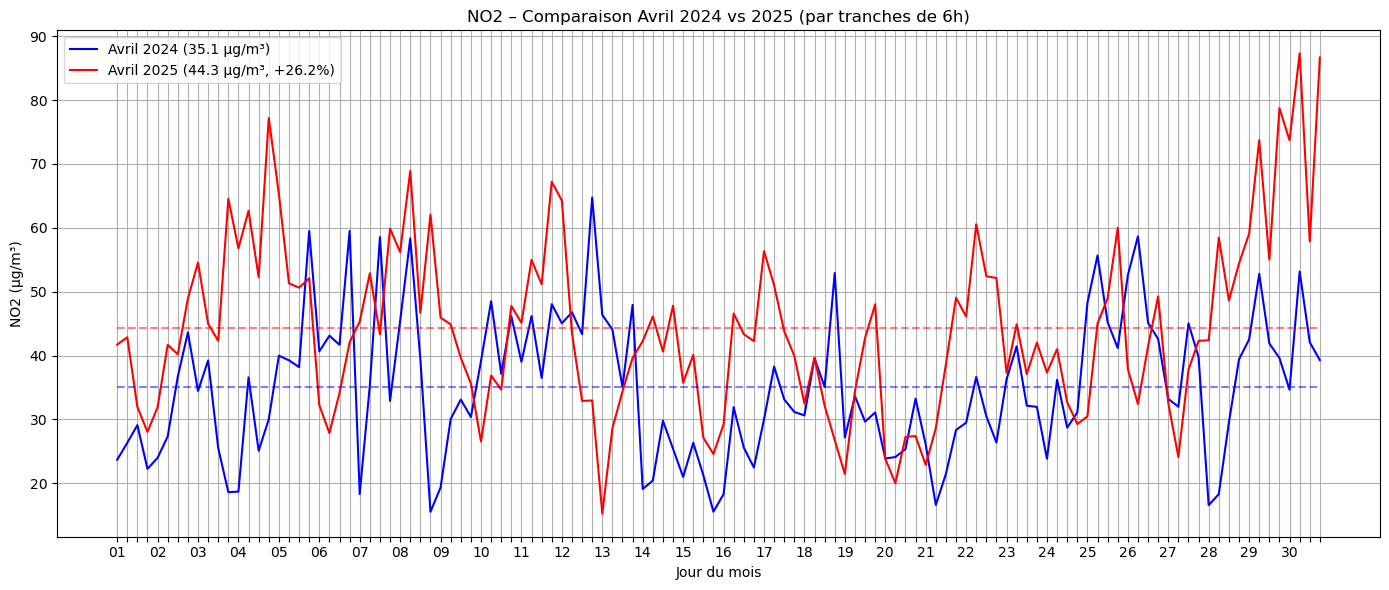

'Analyse complète pour NO2 terminée.'

In [45]:
analyser_polluant_complet("PM10", dossier_base="data")
analyser_polluant_complet("PM25", dossier_base="data")
analyser_polluant_complet("NO2", dossier_base="data")